<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="400" height="600" /> 
    
    
## <font color='navy'> Optimización de Programas de Inversión.
    
### <font color='navy'> Anexo #1: Código de Trabajo

**Profesor:** Sean Nicolás González Vázquez.
    
**Elaboración:** 
- Castillo Meda, Lucía.
- Gutiérrez Valdivia, Juan Carlos.
- Orozco Gómez, Daniel.
- Ponce Anguiano, Carlos Daniel.
- Sánches Paszko, José Walden.
    
**Fecha:** 21 Septiembre 2023.

## Preparación del entorno

In [4]:
# Importar librerías 
import DataFunctions
import ModelFunctions
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from valuation import Companies, Models
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import pandas as pd
#from ydata_profiling import ProfileReport

## Importación de datos y cálculo de fundamentales

In [7]:
# Cargar Datos
income_statement = DataFunctions.load_full_excel('Data/Income/Income_Statement.xlsx')
balance_statement = DataFunctions.load_full_excel('Data/Balance/Balance_Statement.xlsx')
sp500 = DataFunctions.assets(income_statement=income_statement)

# Si se desea cambiar de periodo de analisis cambiar la siguiente fecha:
prices = yf.download(tickers=sp500, start='2018-09-01', end='2023-09-23', progress=False)['Adj Close'] 

In [8]:
# Filtrado de fechas y correcciones temporales
prices_fiscal = DataFunctions.prices_date(balance_statement=balance_statement, prices=prices, sp500=sp500)

# DataFrame limpio con información consolidada de ambos estados financieros y precios
financial_info = DataFunctions.clean_df(balance_statement=balance_statement, 
                                    income_statement=income_statement, 
                                    sp500=sp500, 
                                    prices_fiscal=prices_fiscal)

In [9]:
# Datos en formato tabular
data_table = DataFunctions.tabular_df(financial_info=financial_info, sp500=sp500)

In [10]:
# Cálculo de ratios financieros 
stock = Companies(data_table)
stock.get_ratios()

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return
0,A,2023-06-30,117.226398,3.280427,inf,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1
3,A,2022-09-30,108.403270,3.401820,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0
4,A,2022-06-30,128.247944,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14,XRAY,2019-12-31,197.198245,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1
15,XRAY,2019-09-30,434.443223,1.833476,inf,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0
16,XRAY,2019-06-30,450.749824,1.958479,inf,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1
17,XRAY,2019-03-31,8354.719810,1.679903,inf,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0


## Limpieza de datos

In [78]:
# EDA con miras a limpieza de datos
DataFunctions.dqr(stock.ratios)

,Nombres,Data_Type,Missing_Values,Present_Values,Num_Unique_Values,Min,Max,Categorical,Categories
Stock,Stock,object,0,7372,388,A,XRAY,True,Category too large
fiscalDateEnding,fiscalDateEnding,datetime64[ns],0,7372,19,2018-12-31 00:00:00,2023-06-30 00:00:00,False,Not categorical
PER,PER,float64,37,7335,7319,-123728.496361,inf,False,Not categorical
PBV,PBV,float64,0,7372,7317,0.0,173.594601,False,Not categorical
Acid_test,Acid_test,float64,0,7372,13,3.223702,inf,False,Not categorical
ATR,ATR,float64,0,7372,7233,-0.010471,13.58879,False,Not categorical
CCC,CCC,float64,40,7332,7273,-130229.268944,inf,False,Not categorical
ROA,ROA,float64,0,7372,7077,-5.261343,3.839063,False,Not categorical
DER,DER,float64,0,7372,19,0.76039,1.161746,False,Not categorical
NPM,NPM,float64,37,7335,7262,-inf,inf,False,Not categorical


In [12]:
# Limpieza
stock.clean_ratios()
stock.clean

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return
0,A,2023-06-30,117.226398,3.280427,26.970165,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1
3,A,2022-09-30,108.403270,3.401820,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0
4,A,2022-06-30,128.247944,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14,XRAY,2019-12-31,197.198245,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1
15,XRAY,2019-09-30,434.443223,1.833476,26.970165,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0
16,XRAY,2019-06-30,450.749824,1.958479,26.970165,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1
17,XRAY,2019-03-31,8354.719810,1.679903,26.970165,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0


## Regresión logística

In [9]:
# Regresión Logística
stock.model_input()
valuation_models = Models(stock.input)
valuation_models.split_data()
valuation_models.Logistic_Regression()
valuation_models.Logistic_Regression

Accuracy: 0.6237288135593221
Confusion Matrix:
 [[920   0]
 [555   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77       920
           1       0.00      0.00      0.00       555

    accuracy                           0.62      1475
   macro avg       0.31      0.50      0.38      1475
weighted avg       0.39      0.62      0.48      1475



c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

## Prueba statsmodels, identificar variables significativas

In [10]:
valuation_models.OLS_Regression()
valuation_models.OLS_Regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     83.96
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           2.07e-53
Time:                        18:14:21   Log-Likelihood:                -5024.2
No. Observations:                7372   AIC:                         1.006e+04
Df Residuals:                    7368   BIC:                         1.008e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        343.9315     29.392     11.702      0.000     286.315     401.548
Acid_test     -0.0023      0.000     -7.651      0.000      -0.003      -0.002
DER          343.7727     29.367     11.706      0.000     286.205     401.340
EM          -343.6231     29.379    -11.696      0.000    -401.214    -286.032
==============================================================================
Omnibus:                    31727.097   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1127.493
Skew:                           0.423   Prob(JB):                    1.47e-245
Kurtosis:                       1.281   Cond. No.                     2.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## LDA, identificar variables significativas (en construcción)

## Modelaje 

In [11]:
valuation_models.transformations()

### Estandarizado, cada modelo individual

In [12]:
valuation_models.transformed_models_individual()

-- Gradient Boosting Classifier --
Accuracy (train): 75.6%
Accuracy (test): 73.49%
-- HGBC --
Accuracy (train): 75.58%
Accuracy (test): 73.42%
-- Random Forest Classifier --
Accuracy (train): 77.68%
Accuracy (test): 72.68%
-- XGBoost --
Accuracy (train): 75.94%
Accuracy (test): 72.47%
-- Decision Tree Classifier --
Accuracy (train): 77.68%
Accuracy (test): 72.27%
-- K-Nearest Neighbors (uniformly weighted) --
Accuracy (train): 73.39%
Accuracy (test): 69.63%
-- K-Nearest Neighbors (weighted by distance) --
Accuracy (train): 75.53%
Accuracy (test): 69.29%
-- Support Vector Classifier --
Accuracy (train): 65.32%
Accuracy (test): 65.15%
-- Multilayer Perceptron --
Accuracy (train): 61.35%
Accuracy (test): 62.37%
-- Stochastic Gradient Descent --
Accuracy (train): 61.35%
Accuracy (test): 62.37%
-- Logistic Regression --
Accuracy (train): 61.35%
Accuracy (test): 62.37%
-- Ridge Classifier CV --
Accuracy (train): 61.35%
Accuracy (test): 62.37%
-- Linear Discriminant Analysis --
Accuracy (trai

### Sin estandarización, cada modelo individual

In [13]:
valuation_models.models_individual()

Modelo: Gradient Boosting Classifier
Accuracy en Train: 0.7560
Accuracy en Test: 0.7349
----------------------------------------
Modelo: HGBC
Accuracy en Train: 0.7560
Accuracy en Test: 0.7349
----------------------------------------
Modelo: Random Forest Classifier
Accuracy en Train: 0.7768
Accuracy en Test: 0.7268
----------------------------------------
Modelo: XGBoost
Accuracy en Train: 0.7594
Accuracy en Test: 0.7247
----------------------------------------
Modelo: Decision Tree Classifier
Accuracy en Train: 0.7768
Accuracy en Test: 0.7227
----------------------------------------
Modelo: K-Nearest Neighbors (uniformly weighted)
Accuracy en Train: 0.7461
Accuracy en Test: 0.7146
----------------------------------------
Modelo: K-Nearest Neighbors (weighted by distance)
Accuracy en Train: 0.7729
Accuracy en Test: 0.7105
----------------------------------------
Modelo: Multilayer Perceptron
Accuracy en Train: 0.6892
Accuracy en Test: 0.6895
----------------------------------------
Mo

### Stacking

In [14]:
valuation_models.Stacking_automatic()
valuation_models.Stacking_automatic

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (train): 75.55%
Accuracy (test): 73.29%


StackingClassifier(estimators=[('MLP',
                                MLPClassifier(activation='logistic',
                                              max_iter=1000, random_state=0)),
                               ('SGD', SGDClassifier()),
                               ('KNC_u', KNeighborsClassifier()),
                               ('KNC_d',
                                KNeighborsClassifier(weights='distance')),
                               ('CNB', CategoricalNB()),
                               ('DTC', DecisionTreeClassifier(random_state=0)),
                               ('RFC', RandomForestClassifier(random_state=0)),
                               ('LR',
                                LogisticRegression(max_iter=10000,
                                                   random_state=0)),
                               ('RC', RidgeClassifierCV()),
                               ('LDA', LinearDiscriminantAnalysis()),
                               ('GBC', GradientBoostingClassifier()),
                               ('SV', SVC()),
                               ('HGBC', HistGradientBoostingClassifier())])

In [15]:
valuation_models.Stacking_manual()
valuation_models.Stacking_manual

Accuracy en datos de entrenamiento: 0.7776835679158894
Accuracy en datos de prueba: 0.7186440677966102


LogisticRegression(max_iter=1000, random_state=0)

### Con todas las variables, sin estandarizar variables

In [16]:
valuation_models.load_all(stock.clean)
valuation_models.All_Variables_Models()

Modelo: Gradient Boosting Classifier
Accuracy en Train: 0.7763
Accuracy en Test: 0.7390
----------------------------------------
Modelo: HGBC
Accuracy en Train: 0.8567
Accuracy en Test: 0.7356
----------------------------------------
Modelo: Random Forest Classifier
Accuracy en Train: 1.0000
Accuracy en Test: 0.7268
----------------------------------------
Modelo: XGBoost
Accuracy en Train: 0.9573
Accuracy en Test: 0.7092
----------------------------------------
Modelo: Decision Tree Classifier
Accuracy en Train: 1.0000
Accuracy en Test: 0.6488
----------------------------------------
Modelo: Multilayer Perceptron
Accuracy en Train: 0.6264
Accuracy en Test: 0.6271
----------------------------------------
Modelo: Logistic Regression
Accuracy en Train: 0.6130
Accuracy en Test: 0.6244
----------------------------------------
Modelo: Support Vector Classifier
Accuracy en Train: 0.6137
Accuracy en Test: 0.6244
----------------------------------------
Modelo: Linear Discriminant Analysis
Acc

## Bagging con GBC (default, todas las variables, sin estandarizar)

In [17]:
valuation_models.GBC_Bagging(All_Vars = True)
valuation_models.GBC_Bagging

Bagging with all the variables
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       920
           1       0.71      0.51      0.59       555

    accuracy                           0.74      1475
   macro avg       0.73      0.69      0.70      1475
weighted avg       0.73      0.74      0.73      1475



BaggingClassifier(estimator=GradientBoostingClassifier())

Confusion Matrix with Training Data


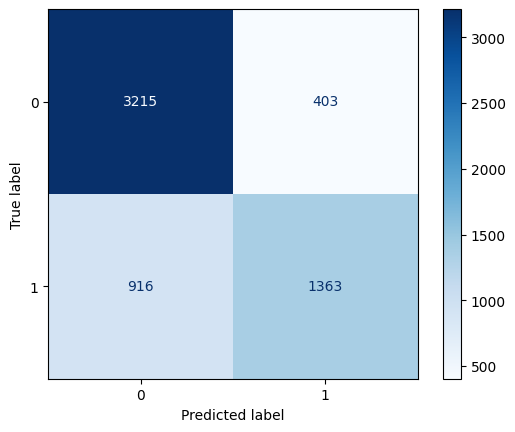

Classification Report with Training
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      3618
           1       0.77      0.60      0.67      2279

    accuracy                           0.78      5897
   macro avg       0.78      0.74      0.75      5897
weighted avg       0.78      0.78      0.77      5897



In [18]:
GBC_control = valuation_models.GBC_All
valuation_models.ConfusionMatrix(GBC_control, training = True)
valuation_models.ClassificationReport(GBC_control, training = True)


Confusion Matrix with Predicted Values


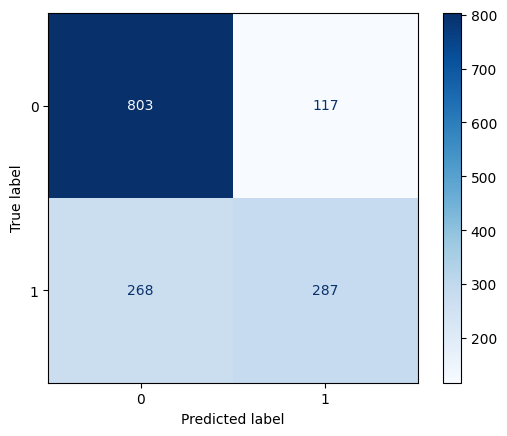

Classification Report with Predicted Values
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       920
           1       0.71      0.52      0.60       555

    accuracy                           0.74      1475
   macro avg       0.73      0.69      0.70      1475
weighted avg       0.73      0.74      0.73      1475



In [19]:
valuation_models.ConfusionMatrix(GBC_control, training = False)
valuation_models.ClassificationReport(GBC_control, training = False)

Confusion Matrix with Training Data


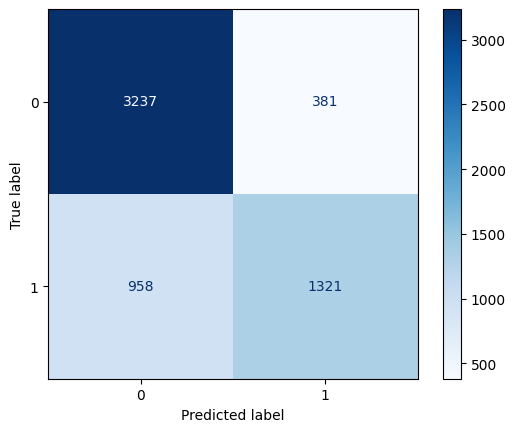

Classification Report with Training
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3618
           1       0.78      0.58      0.66      2279

    accuracy                           0.77      5897
   macro avg       0.77      0.74      0.75      5897
weighted avg       0.77      0.77      0.76      5897



In [20]:
GBC_with_Bagging = valuation_models.GBC_Bagging
valuation_models.ConfusionMatrix(GBC_with_Bagging, training = True)
valuation_models.ClassificationReport(GBC_with_Bagging, training = True)

Confusion Matrix with Predicted Values


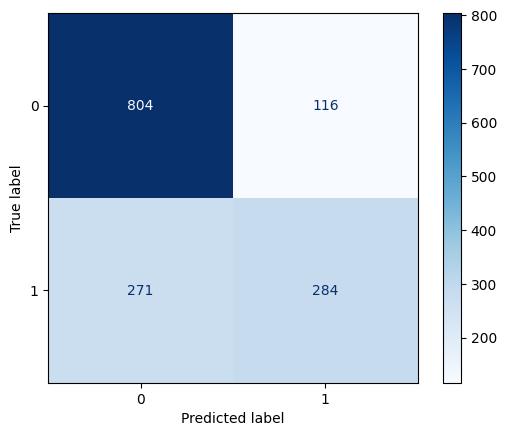

Classification Report with Predicted Values
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       920
           1       0.71      0.51      0.59       555

    accuracy                           0.74      1475
   macro avg       0.73      0.69      0.70      1475
weighted avg       0.73      0.74      0.73      1475



In [21]:
valuation_models.ConfusionMatrix(GBC_with_Bagging, training = False)
valuation_models.ClassificationReport(GBC_with_Bagging, training = False)

In [22]:
# Save Model
valuation_models.save(GBC_with_Bagging, 'GBC_bagging_model.pkl')

### Stacking con GBC control Y GBC con bagging

In [23]:
# 1. Realizar predicciones de los modelos base en los datos de entrenamiento y prueba
models = [GBC_control, GBC_bag]
train_predictions = []
test_predictions = []

for model in models:
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_predictions.append(train_pred)
    test_predictions.append(test_pred)

# 2. Apilar las predicciones de los modelos base en un nuevo conjunto de datos
stacked_train = np.column_stack(train_predictions)
stacked_test = np.column_stack(test_predictions)

# 3. Entrenar un modelo final (meta-modelo)
meta_model = LogisticRegression(max_iter=1000, random_state=0)
meta_model.fit(stacked_train, y_train)

# Calcular el accuracy en los datos de entrenamiento y prueba
train_accuracy = accuracy_score(y_train, meta_model.predict(stacked_train))
test_accuracy = accuracy_score(y_test, meta_model.predict(stacked_test))

print("Accuracy en datos de entrenamiento:", train_accuracy)
print("Accuracy en datos de prueba:", test_accuracy)

NameError: name 'GBC_bag' is not defined

## Clustering

In [ ]:
industry = pd.read_excel('Data/SP500 List/sp500.xlsx')

In [ ]:
industry = industry[["Symbol","GICS_Sector"]]

In [ ]:
result_df = pd.merge(stock.ratios, industry[['Stock', 'Industry']], on='Stock', how='left').drop(["Industry_x"],axis=1)

KeyError: "None of [Index(['Stock', 'Industry'], dtype='object')] are in the [columns]"

In [ ]:
result_df

NameError: name 'result_df' is not defined

In [ ]:
result_df["Industry_y"].unique()

In [ ]:
industry_type_t = result_df["Industry_y"].unique()[1]

In [ ]:
industry_type_t

In [ ]:
result_df[result_df["Industry_y"]==industry_type_t][["PER","PBV","Acid_test","ATR","CCC","ROA","DER","NPM","EM"]]

In [ ]:
# y_pred_bag_train, y_pred_bag, X_train, X_test, GBC_bag, y_test

In [ ]:
for i in range(len(result_df["Industry_y"].unique())):
    y_pred_ind = GBC_bag.predict(result_df[result_df["Industry_y"]==result_df["Industry_y"].unique()[i]][["PER","PBV","Acid_test","ATR","CCC","ROA","DER","NPM","EM"]])
    print(result_df["Industry_y"].unique()[i])
    print(classification_report(result_df[result_df["Industry_y"]==result_df["Industry_y"].unique()[i]][["Return"]], y_pred_ind))

## Conclusines (discutir)
* Tomando todas las variables, en el train nos da mejor (a veces overfitting), pero en test usualmente peor, ¿qué tomamos?
* Sería bueno conseguir más datos? 
* Alguna otra técnica o modelo que nos recomiendes?
* Hicimos stacking con todas las variables, y solo con las significativas. Con todas las variables no fue bueno, pero con las significativas encontramos un buen modelo, haciendolo de manera manual (no sklearn).

* XGBoost dio mejor tomando todas las variables
* Es mejor no estandarizar las variables para todos los modelos

## Exploratory Data Analysis (EDA)

### Profile Report

In [ ]:
# Reporte automatizado utilizando ydata_profiling
#profile = ProfileReport(stock.ratios)
#profile.to_file('Preliminary Report.html')
#profile

### Análisis de correlación

In [ ]:
# Mapear correlación completa
sns.heatmap(
    stock.ratios.corr(numeric_only=True), 
    vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, 
    annot_kws={'size': 10},  linewidth=1, center = 0.2
);

### Histogramas

In [ ]:
# Conservar solo ratios
ratios_only_full = stock.ratios[['PER','PBV','Acid_test','ATR','CCC','ROA','DER','NPM','EM']]

# Drop de valores atípicos en las distribuciones mediante Z_scores
## PER
z_scores = np.abs((ratios_only_full['PER'] - ratios_only_full['PER'].mean()) / ratios_only_full['PER'].std())
per_no_outliers = ratios_only_full['PER'][z_scores <= .4]
per_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(per_no_outliers))/len(ratios_only_full))*100)

## PBV
z_scores = np.abs((ratios_only_full['PBV'] - ratios_only_full['PBV'].mean()) / ratios_only_full['PBV'].std())
pbv_no_outliers = ratios_only_full['PBV'][z_scores <= 3]
pbv_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(pbv_no_outliers))/len(ratios_only_full))*100)

## Acid test
z_scores = np.abs((ratios_only_full['Acid_test'] - ratios_only_full['Acid_test'].mean()) / ratios_only_full['Acid_test'].std())
at_no_outliers = ratios_only_full['Acid_test']
at_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(at_no_outliers))/len(ratios_only_full))*100)

## ATR
z_scores = np.abs((ratios_only_full['ATR'] - ratios_only_full['ATR'].mean()) / ratios_only_full['ATR'].std())
atr_no_outliers = ratios_only_full['ATR'][z_scores <= 3]
atr_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(atr_no_outliers))/len(ratios_only_full))*100)

## CCC
z_scores = np.abs((ratios_only_full['CCC'] - ratios_only_full['CCC'].mean()) / ratios_only_full['CCC'].std())
ccc_no_outliers = ratios_only_full['CCC']
ccc_no_outliers = ccc_no_outliers[ccc_no_outliers <= 10000]
ccc_no_outliers = ccc_no_outliers[ccc_no_outliers >= -10000]
ccc_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(ccc_no_outliers))/len(ratios_only_full))*100)

## ROA
z_scores = np.abs((ratios_only_full['ROA'] - ratios_only_full['ROA'].mean()) / ratios_only_full['ROA'].std())
roa_no_outliers = ratios_only_full['ROA'][z_scores <= 2.4]
roa_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(roa_no_outliers))/len(ratios_only_full))*100)

## DER
z_scores = np.abs((ratios_only_full['DER'] - ratios_only_full['DER'].mean()) / ratios_only_full['DER'].std())
der_no_outliers = ratios_only_full['DER']
der_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(der_no_outliers))/len(ratios_only_full))*100)

## NPM
z_scores = np.abs((ratios_only_full['NPM'] - ratios_only_full['NPM'].mean()) / ratios_only_full['NPM'].std())
npm_no_outliers = ratios_only_full['NPM'][z_scores <= .035]
npm_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(npm_no_outliers))/len(ratios_only_full))*100)

## EM
z_scores = np.abs((ratios_only_full['EM'] - ratios_only_full['EM'].mean()) / ratios_only_full['EM'].std())
em_no_outliers = ratios_only_full['EM']
em_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(em_no_outliers))/len(ratios_only_full))*100)

# Concentrado de nuevos valores
ratios = ['PER', 'PBV', 'Acid_test', 'ATR', 'CCC', 'ROA', 'DER', 'NPM', 'EM']
ratios_num = [per_num,pbv_num,at_num,atr_num,ccc_num,roa_num,der_num,npm_num,em_num]

# Gráficos
plots = [sns.displot(x=data, kde=True) for data in 
         [per_no_outliers, pbv_no_outliers,  at_no_outliers, atr_no_outliers, ccc_no_outliers, 
          roa_no_outliers, der_no_outliers,npm_no_outliers, em_no_outliers]]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for i, plot in enumerate(plots):
    plot.fig.set_size_inches(4, 4)                 
    plot.ax.set_title(ratios[i])                 
    plot.savefig("temp.png")                 
    temp_img = plt.imread("temp.png")                 
    axes[i].imshow(temp_img)                 
    axes[i].axis("off")                 
plt.tight_layout()
plt.show()

In [ ]:
# Cálculo de valores removidos
removed_vals = {'StringColumn': ratios, '% de datos en la gráfica': ratios_num}
removed_vals = pd.DataFrame(removed_vals)
removed_vals

### Análisis de correlación Spearman

In [ ]:
corr_spearman = stock.ratios.corr(method = "spearman")
corr_spearman

In [ ]:
sns.heatmap(
    corr_spearman.corr(numeric_only=True), 
    vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, 
    annot_kws={'size': 10},  linewidth=1, center = 0.08
);

# backtesting

In [13]:
database = stock.clean
database

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return
0,A,2023-06-30,117.226398,3.280427,26.970165,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1
3,A,2022-09-30,108.403270,3.401820,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0
4,A,2022-06-30,128.247944,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14,XRAY,2019-12-31,197.198245,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1
15,XRAY,2019-09-30,434.443223,1.833476,26.970165,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0
16,XRAY,2019-06-30,450.749824,1.958479,26.970165,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1
17,XRAY,2019-03-31,8354.719810,1.679903,26.970165,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0


In [52]:
import joblib
from locale import setlocale, LC_TIME

loaded_model = joblib.load(open('GBC_bagging_model.pkl', 'rb'))

setlocale(LC_TIME, 'en_US.UTF-8')

# Model
#database.to_csv('data.csv')
data = pd.read_csv('data.csv').drop('Unnamed: 0', axis=1)
data['fiscalDateEnding'] = pd.to_datetime(data['fiscalDateEnding'], format='%Y-%m-%d')
data['Yhat'] = loaded_model.predict(data.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1))
data = data.sort_values(by = 'fiscalDateEnding', ascending = True)

# Prices
prices = stock.df[['Stock','fiscalDateEnding','Adj Close']]
prices = prices.sort_values(by = 'fiscalDateEnding')

data = data.merge(prices, how = 'left', on = ['fiscalDateEnding','Stock'])

In [53]:
import numpy as np

In [54]:
data["fiscalDateEnding"].unique()

array(['2018-12-31T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
       '2019-06-30T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
       '2020-06-30T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
       '2021-06-30T00:00:00.000000000', '2021-09-30T00:00:00.000000000',
       '2021-12-31T00:00:00.000000000', '2022-03-31T00:00:00.000000000',
       '2022-06-30T00:00:00.000000000', '2022-09-30T00:00:00.000000000',
       '2022-12-31T00:00:00.000000000', '2023-03-31T00:00:00.000000000',
       '2023-06-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [55]:
data

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return,Yhat,Adj Close
0,GEN,2018-12-31,-397.673958,0.371745,26.970165,0.071512,906.206897,-0.000935,0.862399,-0.013072,1.863270,0,0,9.880099
1,DISH,2018-12-31,18.623365,0.939512,41.532332,0.396907,209.470823,0.050448,0.862399,0.127103,1.863270,0,0,24.969999
2,DLTR,2018-12-31,103.204542,3.398345,26.970165,0.647207,20.407688,0.032928,0.862399,0.050877,1.863270,0,0,90.320000
3,DOV,2018-12-31,134.515580,2.472537,26.970165,0.204184,95.486986,0.018381,0.862399,0.090022,1.863270,0,0,65.714203
4,DOW,2018-12-31,0.000000,0.000000,26.970165,1.740944,8.315140,0.156812,0.862399,0.090073,1.863270,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,O,2023-06-30,77.305105,1.611831,26.970165,0.087509,2470.839662,0.020850,0.866805,0.238264,1.866805,1,1,58.965714
7368,CAT,2023-06-30,36.981872,6.658245,28.972981,1.469792,54.782167,0.180041,0.866805,0.122494,1.866805,0,1,243.578903
7369,INTU,2023-06-30,64.541379,12.481269,27.784301,0.551798,220.243218,0.193384,0.866805,0.350462,1.866805,0,1,456.602905
7370,CARR,2023-06-30,39.314879,1.358826,26.970165,0.490085,380.674653,0.034563,0.866805,0.070524,1.866805,0,1,49.709999


In [64]:
investment_rf = {0: 1, 
                 1: 0.8, 
                 2: 0.6, 
                 3: 0.4, 
                 4: 0.2, 
                 5: 0}

In [125]:
initial_capital = 1000000
comision = .00025

#date = '2018-12-31'
date = '2019-06-30'
trade_period = data[data['fiscalDateEnding'] == date]
traded_portfolio = trade_period[trade_period['Yhat'] == 1].sample(n = 5)

traded_portfolio['Q'] = (initial_capital/traded_portfolio['Adj Close'])
traded_portfolio

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return,Yhat,Adj Close,Q
910,HAL,2019-06-30,44.068526,0.742454,26.970165,0.635890,1095.398168,0.016848,0.76039,0.026495,1.76039,1,1,21.130650,0.000021
1095,AMCR,2019-06-30,26.937668,0.336198,26.970165,0.256030,195.651929,0.012481,0.76039,0.048747,1.76039,1,1,9.568398,0.000010
894,HPE,2019-06-30,9.777739,0.454098,26.970165,0.792507,129.665231,0.046442,0.76039,0.058601,1.76039,0,1,12.923890,0.000013
978,CI,2019-06-30,33.813229,5.276993,45.186193,4.302705,10.531156,0.156063,0.76039,0.036271,1.76039,1,1,150.186203,0.000150
999,IP,2019-06-30,25.208322,1.184696,26.970165,0.610729,328.803615,0.046996,0.76039,0.076951,1.76039,1,1,33.717129,0.000034


In [64]:
for date in data['fiscalDateEnding']:
    

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return,Yhat
0,A,2023-06-30,117.226398,3.280427,26.970165,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1,0
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1,0
3,A,2022-09-30,108.403277,3.401820,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0,0
4,A,2022-06-30,128.247944,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,XRAY,2019-12-31,197.198287,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1,1
7368,XRAY,2019-09-30,434.443223,1.833476,26.970165,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0,0
7369,XRAY,2019-06-30,450.749762,1.958478,26.970165,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1,0
7370,XRAY,2019-03-31,8354.718463,1.679903,26.970165,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0,0


In [34]:
stock_pool = data[data['fiscalDateEnding']==dates[2]]
portfolio = []
initial_capital = 1000000
sample = stock_pool.sample(n=1)
stock_fundamentals = sample.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1)
is_worth_investing = loaded_model.predict(stock_fundamentals)[0]
is_worth_investing

0

In [53]:
data['Yhat'] = loaded_model.predict(data.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Invest


In [50]:
data

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return
0,A,2023-06-30,117.226398,3.280427,26.970165,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1
3,A,2022-09-30,108.403277,3.401820,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0
4,A,2022-06-30,128.247944,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7367,XRAY,2019-12-31,197.198287,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1
7368,XRAY,2019-09-30,434.443223,1.833476,26.970165,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0
7369,XRAY,2019-06-30,450.749762,1.958478,26.970165,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1
7370,XRAY,2019-03-31,8354.718463,1.679903,26.970165,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0


,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM,Return,Invest
0,A,2023-06-30,117.226398,3.280427,26.970165,0.156505,484.824339,0.027984,0.866805,0.178804,1.866805,1,1
1,A,2023-03-31,115.687540,3.729464,12.466387,0.159538,473.104821,0.032237,0.946693,0.202067,1.946693,1,0
2,A,2022-12-31,119.300066,4.168479,76.111111,0.174041,425.001250,0.034941,0.985297,0.200764,1.985297,1,0
3,A,2022-09-30,108.403277,3.401820,14.888889,0.163201,419.650125,0.031381,1.059320,0.192285,2.059320,0,0
4,A,2022-06-30,128.247944,3.361065,15.462857,0.151698,416.910303,0.026208,1.041195,0.172762,2.041195,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7367,XRAY,2019-12-31,197.198287,1.773366,4.074675,0.101090,520.351878,0.008993,0.990733,0.088959,1.990733,1,1
7368,XRAY,2019-09-30,434.443223,1.833476,26.970165,0.116104,445.294066,0.004220,0.816937,0.036349,1.816937,0,0
7369,XRAY,2019-06-30,450.749762,1.958478,26.970165,0.104921,447.986379,0.004345,0.760390,0.041411,1.760390,1,0
7370,XRAY,2019-03-31,8354.718463,1.679903,26.970165,0.118376,407.148055,0.000201,0.777601,0.001699,1.777601,0,0


In [44]:
for i in range(len(dates)):
    stock_pool = data[data['fiscalDateEnding']==dates[i]]
    portfolio = []
    initial_capital = 1000000
    x = 0
    while len(portfolio) < 5:
        x += 1
        sample = stock_pool.sample(n=1)
        stock = sample[['Stock']].iloc[0,0]
        stock_fundamentals = sample.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1)
        is_worth_investing = loaded_model.predict(stock_fundamentals)[0]
        if is_worth_investing == 1:
            portfolio.append(stock)
        else:
            pass

Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycle
Cycl

KeyboardInterrupt: 

In [ ]:
portfolio

[]

In [ ]:
import AssetAllocation as AA

In [ ]:
for i in range(len(dates)):
    stock_pool = data[data['fiscalDateEnding']==dates[i]]
    portfolio = []
    initial_capital = 1000000
    while len(portfolio) < 5:
        sample = stock_pool.sample(n=1)
        stock = sample[['Stock']].iloc[0,0]
        stock_fundamentals = sample.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1)
        is_worth_investing = loaded_model.predict(stock_fundamentals)[0]
        if is_worth_investing == 1:
            portfolio.append(stock)
        else:
            pass
    

In [ ]:
portfolio = []
while len(portfolio) < 5:
    sample = most_recent_stock_info.sample(n=1)
    stock = sample[['Stock']].iloc[0,0]
    stock_fundamentals = sample.drop(['Stock', 'fiscalDateEnding', 'Return'], axis=1)
    is_worth_investing = loaded_model.predict(stock_fundamentals)[0]
    if is_worth_investing == 1:
        portfolio.append(stock)
    else:
        pass
print(portfolio)

['MO', 'META', 'CTRA', 'CPRT', 'CARR']


In [ ]:
portfolio = []
a = 5
is_worth_investing = 1
portfolio = portfolio.append(a) if is_worth_investing ==1 else portfolio

In [ ]:
portfolio = []
portfolio = portfolio.append(5)

In [ ]:
portfolio